In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import pandas as pd
import numpy as np
from scipy.sparse import hstack, csr_matrix
from textblob import TextBlob
import nltk
import re
import datetime
import matplotlib.pyplot as plt
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import LinearSVR
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from wordcloud import WordCloud, STOPWORDS 

%matplotlib inline

# Read data files

In [3]:
train = pd.read_csv("C:/Users/Srushti/Desktop/oneapi/training_data.csv")
test = pd.read_csv('C:/Users/Srushti/Desktop/oneapi/test_data.csv')
# submission = pd.read_csv('C:/Users/Srushti/Desktop/oneapi/submission.csv')
test_id = test['IDLink']
test.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,Facebook,GooglePlus,LinkedIn
0,BJ8bLZcYcm,How Millennials Are Changing The Global Economy,But though millennials may have been born into...,Seeking Alpha,economy,17-02-2016 19:09,6,0,3
1,ph8TGKbvNp,China Promises It Will Keep Its Economy Strong,"""""""China's economic fundamentals have not chan...",Fortune,economy,17-02-2016 19:10,5,1,1
2,qJDgUHX7Ay,Fed eyes increased risks for US economy,Many Federal Reserve policymakers saw increase...,Financial Times,economy,17-02-2016 19:10,45,2,40
3,2MVdzsl9s1,Obama to visit Cuba next month: reports,US President Barack Obama will make a historic...,AFP via Yahoo! News,obama,17-02-2016 19:12,17,0,0
4,6QFCqKq50Q,White House: Obama Will Not Attend Justice Sca...,President Barack Obama will not attend Justice...,NBCNews.com,obama,17-02-2016 19:12,5568,181,36


# Explore data

In [4]:
train.head()

,IDLink,Title,Headline,Source,Topic,Facebook,GooglePlus,LinkedIn,SentimentTitle,SentimentHeadline
0,Tr3CMgRv1N,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,-1,-1,-1,0.000000,-0.053300
1,Wc81vGp8qZ,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,-1,-1,-1,0.208333,-0.156386
2,zNGH03CrZH,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,-1,-1,-1,-0.425210,0.139754
3,3sM1H0W8ts,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,-1,-1,-1,0.000000,0.026064
4,wUbnxgvqaZ,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,-1,-1,-1,0.000000,0.141084


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40508 entries, 0 to 40507
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   IDLink             40508 non-null  object 
 1   Title              40508 non-null  object 
 2   Headline           40508 non-null  object 
 3   Source             40390 non-null  object 
 4   Topic              40508 non-null  object 
 5   Facebook           40508 non-null  int64  
 6   GooglePlus         40508 non-null  int64  
 7   LinkedIn           40508 non-null  int64  
 8   SentimentTitle     40508 non-null  float64
 9   SentimentHeadline  40508 non-null  float64
dtypes: float64(2), int64(3), object(5)
memory usage: 3.1+ MB


In [6]:
train.describe()

,Facebook,GooglePlus,LinkedIn,SentimentTitle,SentimentHeadline
count,40508.000000,40508.000000,40508.000000,40508.000000,40508.000000
mean,142.675225,5.016737,14.014269,-0.007364,-0.029286
std,745.148920,22.592353,73.032200,0.135795,0.142007
min,-1.000000,-1.000000,-1.000000,-0.838525,-0.755355
25%,0.000000,0.000000,0.000000,-0.079057,-0.116213
50%,6.000000,0.000000,0.000000,0.000000,-0.027277
75%,39.000000,2.000000,4.000000,0.062500,0.057474
max,40836.000000,1267.000000,3652.000000,0.962354,0.900000


# Check for missing values

In [7]:
train.isnull().sum()

IDLink                 0
Title                  0
Headline               0
Source               118
Topic                  0
Facebook               0
GooglePlus             0
LinkedIn               0
SentimentTitle         0
SentimentHeadline      0
dtype: int64

In [8]:
test.isnull().sum()

IDLink          0
Title           0
Headline        0
Source         57
Topic           0
PublishDate     0
Facebook        0
GooglePlus      0
LinkedIn        0
dtype: int64

In [9]:
train['Source'].value_counts()[:5]

Bloomberg           725
Reuters             559
ABC News            457
Business Insider    442
New York Times      416
Name: Source, dtype: int64

In [10]:
train['Source'] = train['Source'].fillna('Bloomberg')
test['Source'] = test['Source'].fillna('Bloomberg')

# Text columns processing and cleaning

In [11]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop = set(stopwords.words('english'))

def clean(text):
  text_token = word_tokenize(text)
  filtered_text = ' '.join([w.lower() for w in text_token if w.lower() not in stop and len(w) > 2])
  filtered_text = filtered_text.replace(r"[^a-zA-Z]+", '')
  text_only = re.sub(r'\b\d+\b', '', filtered_text)
  clean_text = text_only.replace(',', '').replace('.', '').replace(':', '')
  return clean_text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Srushti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Srushti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Srushti\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
train['Text_Title'] = train['Title'] + ' ' + train['Source'] + ' ' + train['Topic']
test['Text_Title'] = test['Title'] + ' ' + test['Source'] + ' ' + test['Topic']

train['Text_Headline'] = train['Headline'] + ' ' + train['Source'] + ' ' + train['Topic']
test['Text_Headline'] = test['Headline'] + ' ' + test['Source'] + ' ' + test['Topic']

In [13]:
train['Text_Title'][4]

'Tourism, govt spending buoys Thai economy in January The Nation - Thailand&#39;s English news economy'

In [14]:
train['Text_Title'] = [clean(x) for x in train['Text_Title']]
test['Text_Title'] = [clean(x) for x in test['Text_Title']]

train['Text_Headline'] = [clean(x) for x in train['Text_Headline']]
test['Text_Headline'] = [clean(x) for x in test['Text_Headline']]

In [15]:
train['Text_Title'][4]

'tourism govt spending buoys thai economy january nation thailand english news economy'

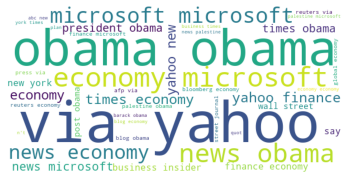

In [16]:
text = ""
for ind, row in train.iterrows():
    text += row["Text_Title"] + " "
text = text.strip()

wordcloud = WordCloud(background_color='white', width=600, height=300, max_font_size=100, max_words=40).generate(text)
wordcloud.recolor(random_state=ind*312)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

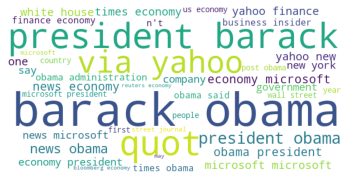

In [17]:
text = ""
for ind, row in train.iterrows():
    text += row["Text_Headline"] + " "
text = text.strip()

wordcloud = WordCloud(background_color='white', width=600, height=300, max_font_size=100, max_words=40).generate(text)
wordcloud.recolor(random_state=ind*312)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Feature extraction from text data

In [18]:
vectorizer = TfidfVectorizer(use_idf=True)

train_v_Title = vectorizer.fit_transform(train['Text_Title'])
test_v_Title = vectorizer.transform(test['Text_Title'])

vectorizer_ = TfidfVectorizer()

train_v_Headline = vectorizer_.fit_transform(train['Text_Headline'])
test_v_Headline = vectorizer_.transform(test['Text_Headline'])

# SVD to reduce dimensions

In [20]:
# svd = TruncatedSVD(n_components=20)

# train_v_Title = svd.fit_transform(train_v_Title)
# test_v_Title = svd.transform(test_v_Title)

# train_v_Headline = svd.fit_transform(train_v_Headline)
# test_v_Headline = svd.transform(test_v_Headline)

# Calculate sentiment of text data

In [19]:
train['polarity_t'] = train['Title'].apply(lambda x: TextBlob(x).sentiment.polarity)
test['polarity_t'] = test['Title'].apply(lambda x: TextBlob(x).sentiment.polarity)

train['subjectivity_t'] = train['Title'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
test['subjectivity_t'] = test['Title'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [20]:
train['polarity_h'] = train['Headline'].apply(lambda x: TextBlob(x).sentiment.polarity)
test['polarity_h'] = test['Headline'].apply(lambda x: TextBlob(x).sentiment.polarity)

train['subjectivity_h'] = train['Headline'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
test['subjectivity_h'] = test['Headline'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Encode categorical columns

In [21]:
encoder = LabelEncoder()

train['Topic'] = encoder.fit_transform(train['Topic'])
test['Topic'] = encoder.transform(test['Topic'])

total = train['Source'].to_list() + test['Source'].to_list()
total = encoder.fit_transform(total)
train['Source'] = encoder.transform(train['Source'])
test['Source'] = encoder.transform(test['Source'])

In [22]:
#words
train["num_words_t"] = train["Text_Title"].apply(lambda x: len(str(x).split()))
test["num_words_t"] = test["Text_Title"].apply(lambda x: len(str(x).split()))

#unique words 
train["num_unique_words_t"] = train["Text_Title"].apply(lambda x: len(set(str(x).split())))
test["num_unique_words_t"] = test["Text_Title"].apply(lambda x: len(set(str(x).split())))

# characters in the Title 
train["num_chars_t"] = train["Text_Title"].apply(lambda x: len(str(x)))
test["num_chars_t"] = test["Text_Title"].apply(lambda x: len(str(x)))

# Average length words 
train["mean_word_len_t"] = train["Text_Title"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test["mean_word_len_t"] = test["Text_Title"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [23]:
#words in the Headline 
train["num_words_h"] = train["Text_Headline"].apply(lambda x: len(str(x).split()))
test["num_words_h"] = test["Text_Headline"].apply(lambda x: len(str(x).split()))

# Number of unique words in the Headline 
train["num_unique_words_h"] = train["Text_Headline"].apply(lambda x: len(set(str(x).split())))
test["num_unique_words_h"] = test["Text_Headline"].apply(lambda x: len(set(str(x).split())))

# Number of characters in the Headline 
train["num_chars_h"] = train["Text_Headline"].apply(lambda x: len(str(x)))
test["num_chars_h"] = test["Text_Headline"].apply(lambda x: len(str(x)))

# Average length of the words in the Headline 
train["mean_word_len_h"] = train["Text_Headline"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test["mean_word_len_h"] = test["Text_Headline"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [24]:
scaler = StandardScaler()

cols = ['Source', 'Topic', 'Facebook', 'GooglePlus', 'LinkedIn', 'num_words_t', 'num_unique_words_t', 'num_chars_t', 'mean_word_len_t',
        'num_words_h', 'num_unique_words_h', 'num_chars_h', 'mean_word_len_h']

for col in cols:
  train[col] = scaler.fit_transform(train[col].values.reshape(-1, 1))
  test[col] = scaler.transform(test[col].values.reshape(-1, 1))

In [25]:
cols_t = ['Source', 'Topic', 'Facebook', 'GooglePlus', 'LinkedIn', 'num_words_t', 'num_unique_words_t', 'num_chars_t', 'mean_word_len_t', 'polarity_t', 'subjectivity_t']
train_X1 = train[cols_t]
test_X1 = test[cols_t]

cols_h = ['Source', 'Topic', 'Facebook', 'GooglePlus', 'LinkedIn', 'num_words_h', 'num_unique_words_h', 'num_chars_h', 'mean_word_len_h', 'polarity_h', 'subjectivity_h']
train_X2 = train[cols_h]
test_X2 = test[cols_h]

In [26]:
train_X1.head()

,Source,Topic,Facebook,GooglePlus,LinkedIn,num_words_t,num_unique_words_t,num_chars_t,mean_word_len_t,polarity_t,subjectivity_t
0,1.246801,0.851842,-0.192816,-0.266321,-0.205587,-0.254347,-0.300421,-0.567699,-0.612870,0.0,0.0
1,-1.324322,-1.099548,-0.192816,-0.266321,-0.205587,-1.661619,-1.712518,-1.624560,0.276170,0.0,0.0
2,-1.324322,-1.099548,-0.192816,-0.266321,-0.205587,-1.192529,-1.241819,-1.030076,0.330601,0.0,0.0
3,0.476858,-1.099548,-0.192816,-0.266321,-0.205587,-1.661619,-1.241819,-2.219044,-1.438408,0.0,0.0
4,1.018954,-1.099548,-0.192816,-0.266321,-0.205587,1.152924,1.111676,1.017592,-0.295356,0.0,0.0


In [27]:
train_X2.head()

,Source,Topic,Facebook,GooglePlus,LinkedIn,num_words_h,num_unique_words_h,num_chars_h,mean_word_len_h,polarity_h,subjectivity_h
0,1.246801,0.851842,-0.192816,-0.266321,-0.205587,-0.282125,-0.523863,-0.487326,-1.059748,0.000000,0.000000
1,-1.324322,-1.099548,-0.192816,-0.266321,-0.205587,-0.282125,-0.228284,-0.313685,-0.174210,0.100000,0.200000
2,-1.324322,-1.099548,-0.192816,-0.266321,-0.205587,-0.410103,-0.671653,-0.296321,0.622774,0.000000,0.041667
3,0.476858,-1.099548,-0.192816,-0.266321,-0.205587,0.101809,0.067295,0.311423,0.848587,-0.166667,0.166667
4,1.018954,-1.099548,-0.192816,-0.266321,-0.205587,0.229788,0.215084,0.398243,0.622774,0.133333,0.380556


In [28]:
print(np.shape(train_X1))
print(np.shape(test_X1))

(40508, 11)
(15424, 11)


In [29]:
print(np.shape(train_X2))
print(np.shape(test_X2))

(40508, 11)
(15424, 11)


In [30]:
print(np.shape(train_v_Title))
print(np.shape(test_v_Title))

(40508, 21672)
(15424, 21672)


In [31]:
print(np.shape(train_v_Headline))
print(np.shape(test_v_Headline))

(40508, 33347)
(15424, 33347)


In [32]:
train_X_Title = hstack([train_v_Title, csr_matrix(train_X1.values)])
test_X_Title = hstack([test_v_Title, csr_matrix(test_X1.values)])
y1 = train['SentimentTitle']

train_X_Headline = hstack([train_v_Headline, csr_matrix(train_X2.values)])
test_X_Headline = hstack([test_v_Headline, csr_matrix(test_X2.values)])
y2 = train['SentimentHeadline']

In [33]:
np.shape(train_X_Title)

(40508, 21683)

# Apply Machine Learning Models

In [66]:
import time
from timeit import default_timer as timer
from IPython.display import HTML
import shap

## SVR Model

In [64]:
from sklearnex import unpatch_sklearn
unpatch_sklearn()

### Title

In [65]:
timeFirstD  = timer()
# LinearSVR model for SentimentTitle

X_train, X_test, y_train, y_test = train_test_split(train_X_Title, y1, test_size=0.20, random_state=42)

clf1 = LinearSVR(C=0.2)
clf1.fit(X_train, y_train)

y_pred1 = clf1.predict(X_test)
mae1 = mean_absolute_error(y_pred1, y_test)
print('MAE:', 1 - mae1)
timeSecondD = timer()

print("Total time with default Scikit-learn: {} seconds".format(timeSecondD - timeFirstD))

MAE: 0.9409813486190333
Total time with default Scikit-learn: 10.269062500000018 seconds


C:\Users\Srushti\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [68]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [70]:
timeFirstI  = timer()
# LinearSVR model for SentimentTitle

X_train, X_test, y_train, y_test = train_test_split(train_X_Title, y1, test_size=0.20, random_state=42)

clf1 = LinearSVR(C=0.2)
clf1.fit(X_train, y_train)

y_pred1 = clf1.predict(X_test)
mae1 = mean_absolute_error(y_pred1, y_test)
print('MAE:', 1 - mae1)
timeSecondI = timer()

print("Total time with intel Scikit-learn: {} seconds".format(timeSecondI - timeFirstI))

MAE: 0.9410077722265451
Total time with intel Scikit-learn: 9.963655300000028 seconds


Liblinear failed to converge, increase the number of iterations.


In [71]:
shap_speedup = round((timeSecondD - timeFirstD) / (timeSecondI - timeFirstI), 2)
HTML(f'<h2>Shap speedup: {shap_speedup}x</h2>'
     f'(from {round((timeSecondD - timeFirstD), 2)} to {round((timeSecondI - timeFirstI), 2)} seconds)')

### Headline

In [109]:
from sklearnex import unpatch_sklearn
unpatch_sklearn()

In [110]:
timeFirstDheadline  = timer()
# LinearSVR model for SentimentHeadline

X_train, X_test, y_train, y_test = train_test_split(train_X_Headline, y2, test_size=0.20, random_state=42)

clf2 = LinearSVR(C=0.1)
clf2.fit(X_train, y_train)

y_pred2 = clf2.predict(X_test)
mae2 = mean_absolute_error(y_pred2, y_test)
print('MAE:', 1 - mae2)
timeSecondDheadline = timer()

print("Total time with default Scikit-learn: {} seconds".format(timeSecondDheadline - timeFirstDheadline))

MAE: 0.9271661570445611
Total time with default Scikit-learn: 13.906246600000031 seconds


Liblinear failed to converge, increase the number of iterations.


In [111]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [112]:
timeFirstIheadline  = timer()
# LinearSVR model for SentimentHeadline

X_train, X_test, y_train, y_test = train_test_split(train_X_Headline, y2, test_size=0.20, random_state=42)

clf2 = LinearSVR(C=0.1)
clf2.fit(X_train, y_train)

y_pred2 = clf2.predict(X_test)
mae2 = mean_absolute_error(y_pred2, y_test)
print('MAE:', 1 - mae2)
timeSecondIheadline = timer()

print("Total time with intel Scikit-learn: {} seconds".format(timeSecondIheadline - timeFirstIheadline))

MAE: 0.9271659752601613
Total time with intel Scikit-learn: 13.281203000000005 seconds


Liblinear failed to converge, increase the number of iterations.


In [113]:
shap_speedup = round((timeSecondDheadline - timeFirstDheadline) / (timeSecondIheadline - timeFirstIheadline), 2)
HTML(f'<h2>Shap speedup: {shap_speedup}x</h2>'
     f'(from {round((timeSecondDheadline - timeFirstDheadline), 2)} to {round((timeSecondIheadline - timeFirstIheadline), 2)} seconds)')

In [114]:
print('MAE:', 1 - ((0.4 * mae1) + (0.6 * mae2)))

MAE: 0.9327026940467148


Make predictions for test dataset

In [115]:
title = clf1.predict(test_X_Title)
headline = clf2.predict(test_X_Headline)

Save results in csv

In [116]:
df = pd.DataFrame()
df['IDLink'] = test_id
df['SentimentTitle'] = title
df['SentimentHeadline'] = headline
df.to_csv('C:/Users/Srushti/Desktop/oneapi/res.csv', index=False)

## XGBoost

In [117]:
import xgboost as xgb

from sklearn.metrics import mean_squared_error

### Headline 

In [135]:
from sklearnex import unpatch_sklearn
unpatch_sklearn()

In [136]:
timerFirstDxg=timer()
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 10, tree_method='hist')
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
timerSecondDxg=timer()

print("Total time with default Scikit-learn: {} seconds".format(timerSecondDxg - timerFirstDxg))

Total time with default Scikit-learn: 0.6733736999999564 seconds


In [137]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [138]:
timerFirstIxg=timer()
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 10, tree_method='hist')
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
timerSecondIxg=timer()

print("Total time with intel Scikit-learn: {} seconds".format(timerSecondIxg - timerFirstIxg))

Total time with intel Scikit-learn: 0.6389931999997316 seconds


In [139]:
shap_speedup = round((timerSecondDxg - timerFirstDxg) / (timerSecondIxg - timerFirstIxg), 2)
HTML(f'<h2>Shap speedup: {shap_speedup}x</h2>'
     f'(from {round((timerSecondDxg - timerFirstDxg), 2)} to {round((timerSecondIxg - timerFirstIxg), 2)} seconds)')

In [123]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE:",rmse)

RMSE: 0.22921635317672098


### Title

In [124]:
X_train, X_test, y_train, y_test = train_test_split(train_X_Title, y1, test_size=0.20, random_state=42)

In [125]:
from sklearnex import unpatch_sklearn
unpatch_sklearn()

In [126]:
timerFirstDxgtitle=timer()

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 10, tree_method='hist')
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
timerSecondDxgtitle=timer()

print("Total time with default Scikit-learn: {} seconds".format(timerSecondDxgtitle - timerFirstDxgtitle))

Total time with default Scikit-learn: 0.6354646999998295 seconds


In [127]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [128]:
timerFirstIxgtitle=timer()

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 10, tree_method='hist')
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
timerSecondIxgtitle=timer()

print("Total time with intel Scikit-learn: {} seconds".format(timerSecondIxgtitle - timerFirstIxgtitle))

Total time with intel Scikit-learn: 0.5982140999999501 seconds


In [129]:
shap_speedup = round((timerSecondDxgtitle - timerFirstDxgtitle) / (timerSecondIxgtitle - timerFirstIxgtitle), 2)
HTML(f'<h2>Shap speedup: {shap_speedup}x</h2>'
     f'(from {round((timerSecondDxgtitle - timerFirstDxgtitle), 2)} to {round((timerSecondIxgtitle - timerFirstIxgtitle), 2)} seconds)')